In [ ]:
include("ct_utils.jl")
using ChargeTransport
using .CTUtils
using DataFrames
using CSV 
using PyPlot

In [ ]:
data_type = ["dark-sc", "illuminated-sc"]
data_choice = 1

generation_filename = "../simulation_data/scaps/si-topcon-auto.gen"

df_ct = ct_to_df("../simulation_data/chargetransport/si-topcon-schottky-$(data_type[data_choice]).csv")
df_scaps = scaps_to_df("../simulation_data/scaps/si-topcon-$(data_type[data_choice]).eb")
df_gen = scaps_to_df_generation(generation_filename)
println("Data loaded successfully.")

Data loaded successfully.


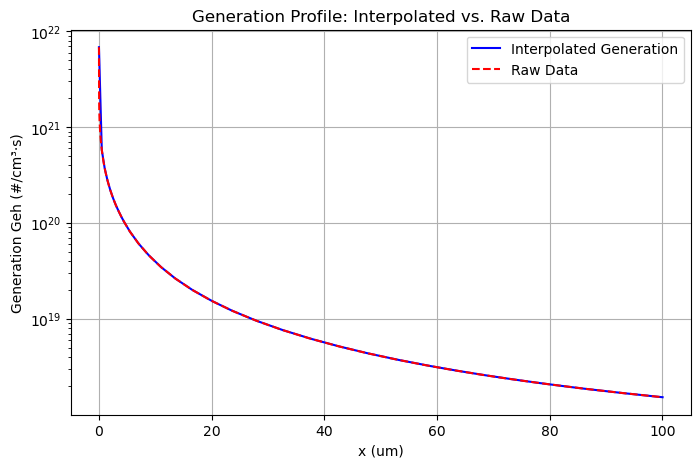

In [4]:
using PyPlot

# Define a range of x values for smooth interpolation
x_vals = range(minimum(df_gen[!, "x (um)"]), stop=maximum(df_gen[!, "x (um)"]), length=200)
G_interp = [generation_from_scaps(generation_filename, x * (μm)) * 1e-6 for x in x_vals]

figure(figsize=(8,5))
plot(x_vals, G_interp, label="Interpolated Generation", color="blue")
plot(df_gen[!, "x (um)"], df_gen[!, "Geh (#/cm3.s)"], linestyle="--", label="Raw Data", color="red")

yscale("log")
xlabel("x (um)")
ylabel("Generation Geh (#/cm³·s)")
title("Generation Profile: Interpolated vs. Raw Data")
legend()
grid(true)
display(gcf())

In [ ]:
G_interp[end - 1]

In [ ]:
generation_from_scaps(generation_filename, 99.557 * (μm))

## COMPARISONS

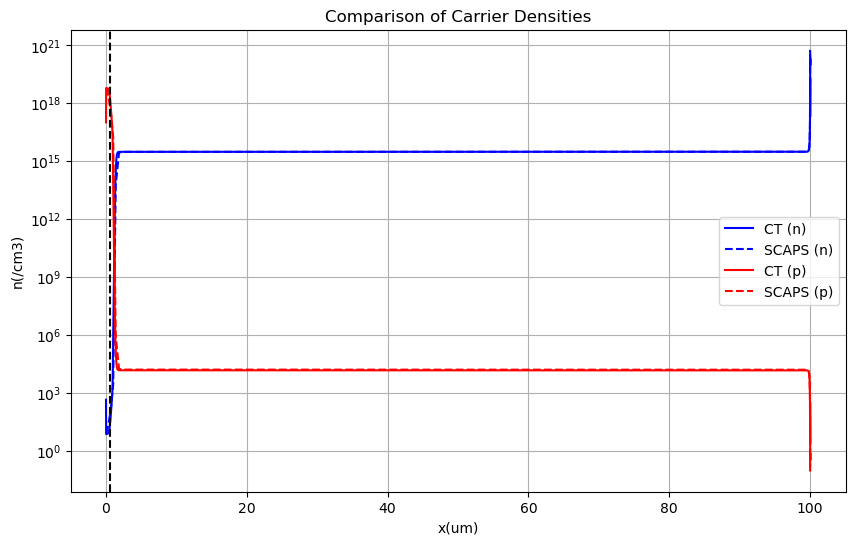

In [5]:
compare_densities(df_ct, df_scaps)
axvline(0.5, color="black", linestyle="--", label="x = 4")
display(gcf())

In [ ]:
edge_coord = 0.5
cz_edge_np_scaps = find_info_scaps(df_scaps, edge_coord).p * find_info_scaps(df_scaps, edge_coord).n
cz_edge_np_ct = find_info_ct(df_ct, edge_coord).p * find_info_ct(df_ct, edge_coord).n

In [ ]:
cz_edge_np_scaps

In [ ]:
cz_edge_np_ct

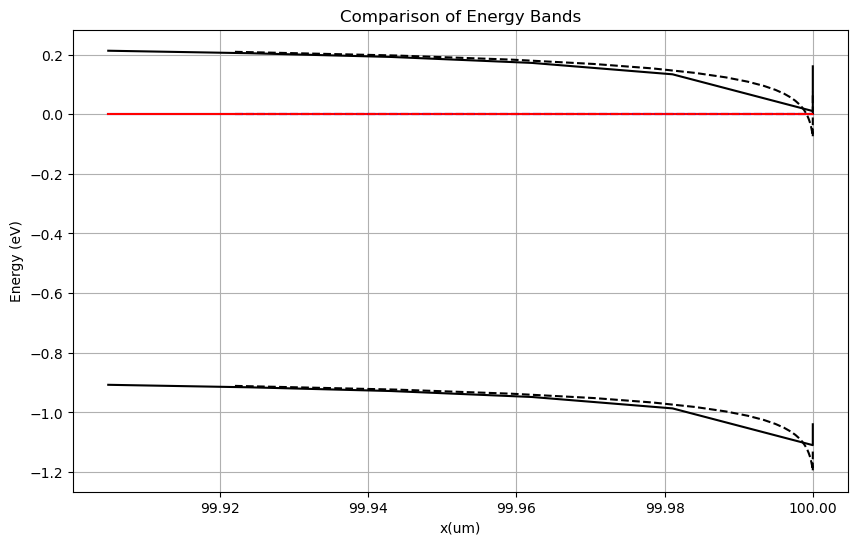

In [6]:
compare_bands(df_ct, df_scaps, xrange=(99.9, 100))
display(gcf())

In [ ]:
using PyPlot

figure(figsize=(10,6))
plot(df_scaps[!, "x(um)"], df_scaps[!, "Ec(eV)"], color="blue")
plot(df_scaps[!, "x(um)"], df_scaps[!, "Ev(eV)"], color="red")
plot(df_scaps[!, "x(um)"], df_scaps[!, "Fn(eV)"], color="green", linestyle=":")
plot(df_scaps[!, "x(um)"], df_scaps[!, "Fp(eV)"], color="orange", linestyle=":")
xlabel("x (um)")
ylabel("Energy (eV)")
title("Band Edges and Quasi-Fermi Levels vs x")
# legend()
grid(true)
display(gcf())

In [ ]:
decay(x) = 6.82e27 * exp(-8.408e4 * x)

In [ ]:
distance = 42.2 * (μm)
decay(distance)

In [ ]:
using DataFrames

filename = "../simulation_data/scaps/si-topcon-auto.gen"
lines = readlines(filename)
# Find the line containing 'GEN'
gen_idx = findfirst(x -> occursin("GEN", x), lines)
if isnothing(gen_idx) || gen_idx == length(lines)
    error("No GEN line or header found in file.")
end
# The header is the line after 'GEN'
header_idx = gen_idx + 1
header = strip.(split(strip(lines[header_idx]), '\t'))
# Replace Greek mu (μ) with 'u' in header names for easier access
header = replace.(header, 'μ' => "u")
# Data starts after the header
data_start = header_idx + 1
data_lines = filter(x -> !isempty(strip(x)), lines[data_start:end])
# Split each data line into fields using tab delimiter
data = [split(strip(line), '\t') for line in data_lines]
# Convert to numbers if possible
data = [map(x -> tryparse(Float64, x) === nothing ? x : parse(Float64, x), row) for row in data]
df_gen = DataFrame([getindex.(data, i) for i in 1:length(header)], Symbol.(header))

In [ ]:
function predict_generation(df::DataFrame, xq::Float64)
    x = df[!, "x (um)"]
    Geh = df[!, "Geh (#/cm3.s)"]

    # Find the interval containing xq
    if xq <= x[1]
        return Geh[1]
    elseif xq >= x[end]
        return Geh[end]
    else
        i = findfirst(i -> x[i] <= xq < x[i+1], 1:length(x)-1)
        println("Interval found: ", i)
        if isnothing(i)
            error("xq is out of bounds or data is not sorted.")
        end
        # Exponential interpolation: Geh(x) = Geh1 * exp(log(Geh2/Geh1) * (xq-x1)/(x2-x1))
        x1, x2 = x[i], x[i+1]
        G1, G2 = Geh[i], Geh[i+1]
        return G1 * exp(log(G2/G1) * (xq - x1) / (x2 - x1))
    end
end

# Example usage:
G_pred = predict_generation(df_gen, 0.5)

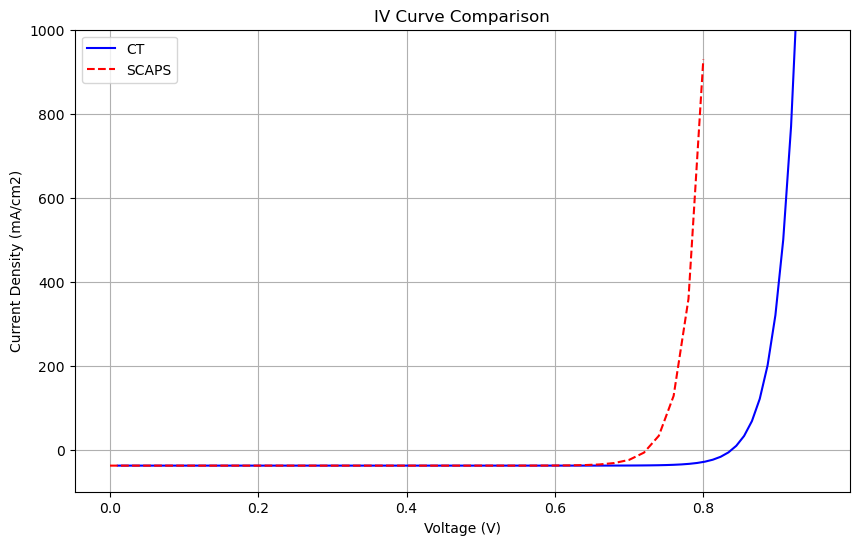

In [3]:
df_ct_iv = CSV.read("../simulation_data/chargetransport/si-topcon-schottky-iv.csv", DataFrame)
df_scaps_iv = scaps_to_df_iv("../simulation_data/scaps/si-topcon.iv")

# test if it's just a horizontal translation
# df_ct_iv[!, "V"] = df_ct_iv[!, "V"] .- 0.113
df_ct_iv[!, "J"] = df_ct_iv[!, "J"] * -0.1

compare_iv(df_ct_iv, df_scaps_iv)
ylim(-100, 1000)
display(gcf())